# 0. Module loading

In [1]:
import os,pandas,dill,datetime,time,numpy
import matplotlib,matplotlib.pyplot
import miner
%matplotlib inline

# 0.1. User defined paths

In [10]:
# 0. user defined variables
inputDataFile='/Volumes/omics4tb2/alomana/projects/PSL/GBM/results/normalization/QN.MA.data.csv'
resultsDirectory='/Volumes/omics4tb2/alomana/projects/PSL/GBM/results/MINER/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

# 1. Read data

In [11]:
expressionData=pandas.read_csv(inputDataFile,header=0,index_col=0,sep=",")
print 'expression data shape',expressionData.shape
expressionData,conversionTable=miner.identifierConversion(expressionData)

expression data shape (11312, 538)
completed identifier conversion.
10663 genes were converted.


# 2. Transform data

In [12]:
expressionData=miner.zscore(expressionData)

completed z-transformation.


# 3. Network inference

## 3.0. Set parameters

In [13]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 8

## 3.1. Co-expression clustering

2019-04-30 12:10:44
0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 16.09 minutes
Number of genes clustered: 10003
Number of unique clusters: 804
Completed clustering module in 16.50 minutes
2019-04-30 12:27:14


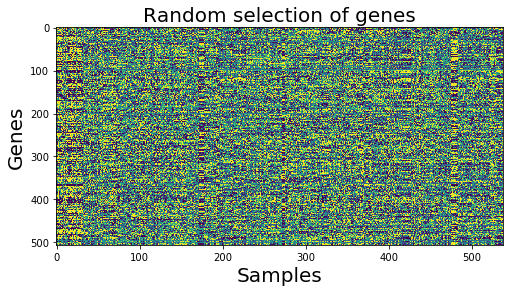

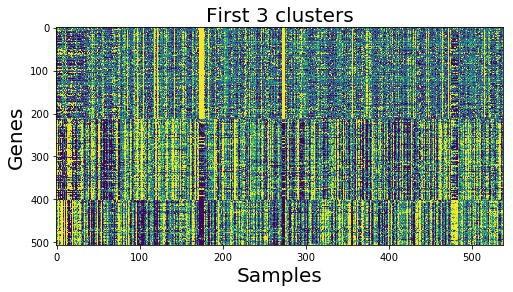

In [15]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
t1 = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# ensure that keys have type str

# retrieve first three clusters for visual inspection
first_clusters = numpy.hstack([revisedClusters[i] for i in numpy.arange(3).astype(str)])

# visualize background expression
matplotlib.pyplot.figure(figsize=(8,4))
matplotlib.pyplot.imshow(expressionData.loc[numpy.random.choice(expressionData.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
matplotlib.pyplot.grid(False)
matplotlib.pyplot.ylabel("Genes",FontSize=20)
matplotlib.pyplot.xlabel("Samples",FontSize=20)
matplotlib.pyplot.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
matplotlib.pyplot.figure(figsize=(8,4))
matplotlib.pyplot.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
matplotlib.pyplot.grid(False)
matplotlib.pyplot.ylabel("Genes",FontSize=20)
matplotlib.pyplot.xlabel("Samples",FontSize=20)
matplotlib.pyplot.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(numpy.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t2 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t2-t1)/60.))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

## 3.2. Mechanistic inference

In [17]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 15:15:03
Running mechanistic inference
Completed mechanistic inference in 3.40 minutes
Inferred network with 2796 regulons, 404 regulators, and 6351 co-regulated genes
2019-04-30 15:18:27


## 3.4. Network mapping

In [21]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 17:58:13
done!
done!
done!
done!
Completed patient mapping in 55.20 minutes
2019-04-30 18:53:25


Text(0.5,0,'Samples')

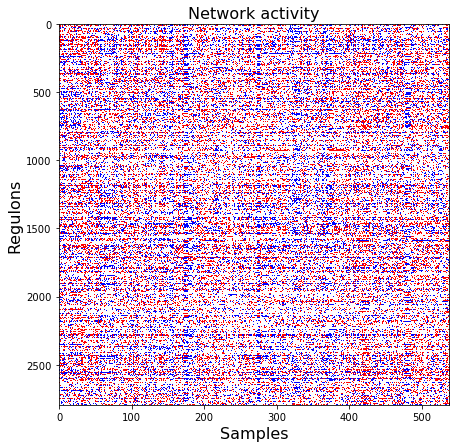

In [26]:
#visualize network activity across individual samples
matplotlib.pyplot.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
matplotlib.pyplot.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
matplotlib.pyplot.title("Network activity",FontSize=16)
matplotlib.pyplot.ylabel("Regulons",FontSize=16)
matplotlib.pyplot.xlabel("Samples",FontSize=16)

## 3.5. Subtype discovery

2019-04-30 19:01:56
done!
2019-04-30 19:04:37


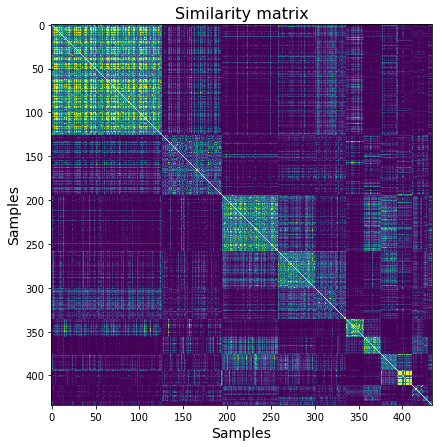

In [27]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,numpy.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 19:04:43
2019-04-30 19:05:03


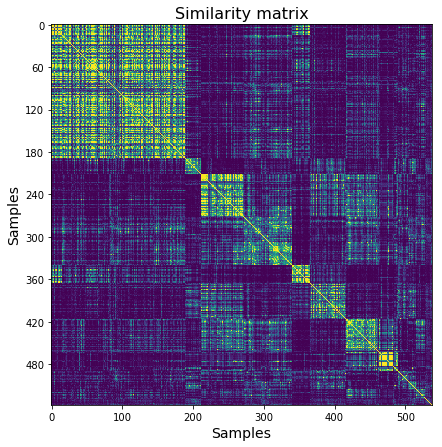

In [28]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[numpy.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in numpy.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 19:13:08
2019-04-30 19:13:09


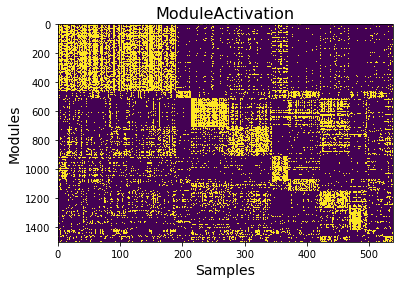

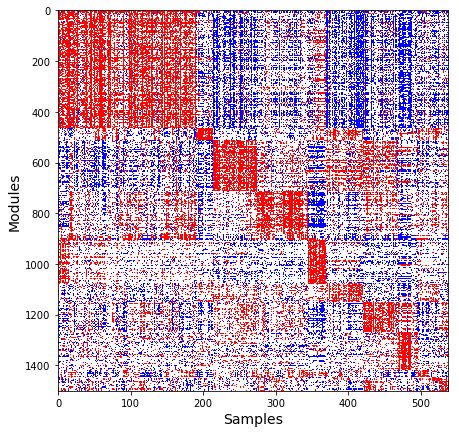

In [31]:
# why first plot is not viridis? If binary, same as below, what's the difference?
# is it ok to have more regulons than modules
# diifference btw regulon and modules again?

print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Generate heatmaps of module activity
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None,showplot=True)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"))
reference_df = network_activity_heatmap.copy()
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 19:14:35
Discovered 22 transcriptional states and 130 transcriptional programs
sample coverage within sufficiently large states: 98.7%


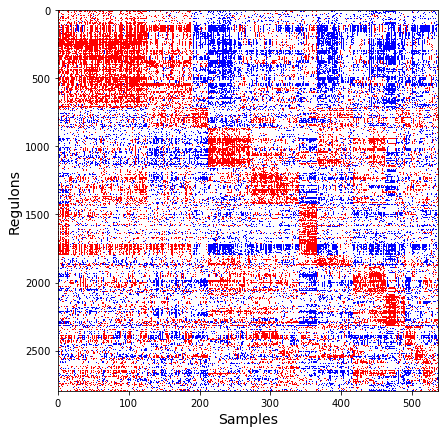

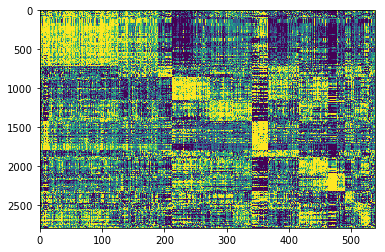

In [32]:
# double check two plots same variable (regulon) but binary or continuos.

print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=reference_df,clusterList=centroidClusters,minClusterSize_x=int(numpy.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[numpy.hstack(program_list),numpy.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))

# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = numpy.percentile(expressionData,95)/numpy.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = numpy.array(eigengenes.index).astype(str)

# write eigengenes to .csv
eigengenes.to_csv(os.path.join(resultsDirectory,"eigengenes.csv"))

# plot eigengenes
matplotlib.pyplot.figure()
matplotlib.pyplot.imshow(eigengenes.loc[numpy.hstack(program_list),numpy.hstack(states)],cmap="viridis",vmin=-1,vmax=1,aspect="auto")
matplotlib.pyplot.grid(False)

# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(numpy.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(numpy.hstack(groups)))/expressionData.shape[1]))

# write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    numpy.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

In [33]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=os.path.join(resultsDirectory,"transcriptional_programs_vs_samples.pdf"))

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 19:18:42


KeyError: u"None of [Index([u'6', u'10', u'39', u'84', u'119', u'126', u'146', u'180', u'207',\n       u'213',\n       ...\n       u'2465', u'2545', u'2561', u'2616', u'2624', u'2688', u'2698', u'2713',\n       u'2765', u'2778'],\n      dtype='object', length=110)] are in the [index]"

## 3.6. Causal inference

In [34]:
# Load mutation matrices
common_mutations_file = "/Volumes/omics4tb2/alomana/projects/PSL/GBM/data/mutations/mutations.GBM.TCGA.2019.04.30.csv"
common_mutations = pandas.read_csv(common_mutations_file,index_col=0,header=0)

In [36]:
common_mutations.head()

,TCGA-74-6584-01,TCGA-06-0137-01,TCGA-32-4209-01,TCGA-06-0171-02,TCGA-06-0155-01,TCGA-27-1836-01,TCGA-06-2558-01,TCGA-12-0821-01,TCGA-06-0649-01,TCGA-41-2573-01,...,TCGA-19-5953-01,TCGA-06-0221-02,TCGA-14-1034-02,TCGA-06-0139-01,TCGA-32-2494-01,TCGA-74-6575-01,TCGA-06-2561-01,TCGA-27-1838-01,TCGA-28-1753-01,TCGA-06-6700-01
PTEN,0,0,0,0,1,0,1,0,1,1,...,1,0,1,0,0,0,1,1,1,0
TP53,0,0,0,0,0,1,1,0,0,0,...,0,1,1,0,0,0,0,1,1,0
EGFR,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,1,0,1
TTN,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,0
MUC16,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [35]:
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.head()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2796 elements

In [ ]:
# generate output for web portal visualization
wiringDiagramOutput = os.path.join(resultsDirectory,"wiring_diagram.csv")
wireDiagram = wiringDiagram(causal_results,regulonModules,coherent_samples_matrix,include_genes=False,savefile=wiringDiagramOutput)
wireDiagram.head()